In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
import mne
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

In [45]:
# class EEGDataset(Dataset):
#     def __init__(self, data_dir, get_annotation, data_extension='edf', filter=None, target_filter=None, drop_channels=None):
#         self.data_dir = data_dir
#         self.get_annotation = get_annotation
#         all_dir_files = os.listdir(data_dir)
#         self.data_files_path = [file for file in all_dir_files if file.endswith(f'.{data_extension}')]
#         self.filter = filter
#         self.target_filter = target_filter
#         self.drop_channels = drop_channels

#     def __len__(self):
#         return len(self.data_files_path)

#     def __getitem__(self, idx):
#         file_path = f'{self.data_dir}\\{self.data_files_path[idx]}'
#         eeg = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
#         if self.drop_channels:
#             eeg.drop_channels(self.drop_channels)
#         label = get_annotation(file_path)
#         if self.filter:
#             eeg = self.filter(eeg)
#         if self.target_filter:
#             label = self.target_filter(label)
#         if isinstance(eeg, mne.io.edf.edf.RawEDF):
#             eeg = eeg.get_data()
#         elif not isinstance(eeg, np.ndarray):
#             eeg = np.array(eeg)
#         eeg = eeg.astype(np.float32)
#         label = np.int64(label)
#         return eeg, label


# def get_annotation(eeg_path: str, data_extension: str = 'edf') -> int:
#     if eeg_path.endswith(f'_1.{data_extension}'):
#         return 0
#     elif eeg_path.endswith(f'_2.{data_extension}'):
#         return 1
#     raise Exception('Неизвестный формат файла')

# def filter_data_func(*filters):
#     def _filter_data(data):
#         for filt in filters:
#             data = filt(data)
#         return data
#     return _filter_data

# def crop_eeg_func(size):
#     def _crop(data):
#         return data.crop(tmax=size, include_tmax=False)
#     return _crop

# def freq_mean_func(freqs):
#     def _freq_mean(data):
#         data_freqs = []  # По-хорошему словарь сюда бы
#         for freq_l, freq_r in freqs:
#             copy_data = data.copy()
#             copy_data.filter(freq_l,
#                              freq_r,
#                              n_jobs=None,  
#                              l_trans_bandwidth=1,
#                              h_trans_bandwidth=1,
#                              verbose=False)
#             data_freqs.append(copy_data.get_data().mean(axis=1))
#         return np.array(data_freqs)
#     return _freq_mean

# def normalize(data):
#     mean = data.mean()
#     std = data.std()
#     return (data-mean)/std

# def normalize_minmax(data):
#     min = data.min()
#     max = data.max()
    
#     return (data-min)/(max-min)

In [3]:
class StressRecognitionNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.flatten = nn.Flatten(1)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
        )

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [4]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))

        loss.backward()
        optimizer.step()

        if batch % 5 == 0:
            loss = loss.item()
            current = batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, accuracy = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device))
            test_loss += loss_fn(pred, y.to(device)).item()
            accuracy += (pred.detach().cpu().argmax(dim=1) == y).type(torch.float).sum().item()
            
    test_loss /= size
    accuracy /= size
    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, accuracy

In [78]:
learning_rate = 1e-3
batch_size = 32
epochs = 100
best_model_path = 'best-model-parameters.pt'

In [73]:
with open(r"C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Признаки\features_02.npy", mode='rb') as f:
    features = np.load(f)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(features[:, 1:], features[:, 0], test_size=0.5, random_state=100)

In [144]:
# X_test, y_test, X_valid, y_valid = X_test[:100], y_test[:100], X_test[100:], y_test[100:]

In [98]:
train = torch.tensor(X_train.astype(np.float32))
train_target = torch.tensor(y_train, dtype=torch.long)
train_dataset = torch.utils.data.TensorDataset(train, train_target)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test = torch.tensor(X_test.astype(np.float32))
test_target = torch.tensor(y_test, dtype=torch.long)
test_dataset = torch.utils.data.TensorDataset(test, test_target)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [99]:
input_size = X_train.shape[1]
stress_nn = StressRecognitionNetwork(input_size)
stress_nn.to(device)

StressRecognitionNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=352, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [100]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(stress_nn.parameters(), lr=learning_rate)
test_losses, accuracies = [], []
best_accuracy = 0

for i in range(1, epochs+1):
    print(f"Epoch {i}\n-------------------------------")
    train_loop(train_loader, stress_nn, loss_fn, optimizer)
    test_loss, accuracy = test_loop(test_loader, stress_nn, loss_fn)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(stress_nn.state_dict(), best_model_path)
    
print("Done!")

Epoch 1
-------------------------------
loss: 1.312490  [   32/  167]
loss: 1.265317  [  167/  167]
Test Error: 
 Accuracy: 60.5%, Avg loss: 0.029201 

Epoch 2
-------------------------------
loss: 1.176088  [   32/  167]
loss: 0.849218  [  167/  167]
Test Error: 
 Accuracy: 66.5%, Avg loss: 0.022968 

Epoch 3
-------------------------------
loss: 0.733409  [   32/  167]
loss: 0.692807  [  167/  167]
Test Error: 
 Accuracy: 67.7%, Avg loss: 0.027293 

Epoch 4
-------------------------------
loss: 0.595097  [   32/  167]
loss: 0.481742  [  167/  167]
Test Error: 
 Accuracy: 74.3%, Avg loss: 0.016698 

Epoch 5
-------------------------------
loss: 0.406567  [   32/  167]
loss: 0.135473  [  167/  167]
Test Error: 
 Accuracy: 75.4%, Avg loss: 0.016179 

Epoch 6
-------------------------------
loss: 0.320618  [   32/  167]
loss: 0.544026  [  167/  167]
Test Error: 
 Accuracy: 77.2%, Avg loss: 0.021085 

Epoch 7
-------------------------------
loss: 0.450827  [   32/  167]
loss: 0.456232  [ 

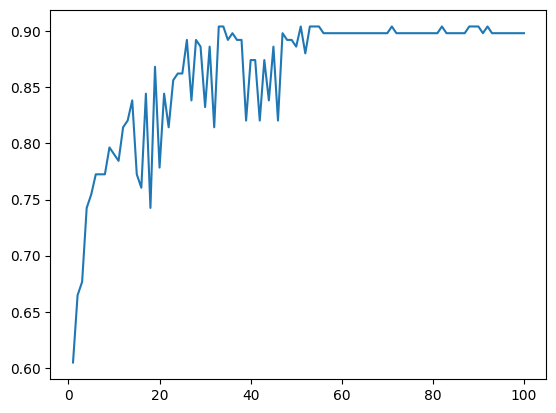

In [101]:
plt.plot(range(1, len(accuracies)+1), accuracies)

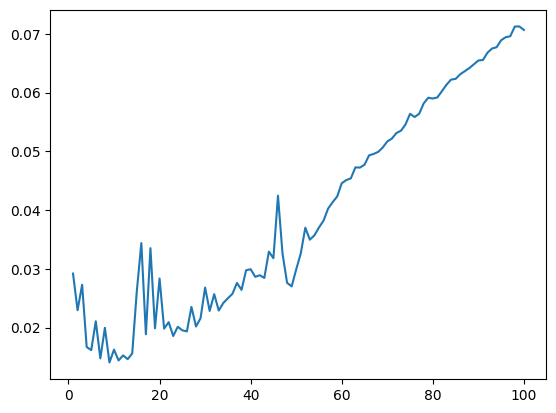

In [102]:
plt.plot(range(1, len(test_losses)+1), test_losses)

In [112]:
stress_nn.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [113]:
y_test = []
y_pred = []
for X, y in test_loader:
    y_test.extend(y)
    pred = stress_nn(X.to(device))
    y_pred.extend(pred.detach().cpu().argmax(dim=1))
cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=['Stress', 'Not stress'])
print(clr)

              precision    recall  f1-score   support

      Stress       0.91      0.93      0.92        97
  Not stress       0.90      0.87      0.88        70

    accuracy                           0.90       167
   macro avg       0.90      0.90      0.90       167
weighted avg       0.90      0.90      0.90       167



In [125]:
x = test_loader.dataset.tensors[0][10]

In [163]:
%%timeit -r 20 -n 5
stress_nn(X.to(device)).detach().cpu().argmax()

852 µs ± 119 µs per loop (mean ± std. dev. of 20 runs, 5 loops each)


In [106]:
print(stress_nn)

StressRecognitionNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=352, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [83]:
cm

array([[88,  9],
       [ 7, 63]], dtype=int64)

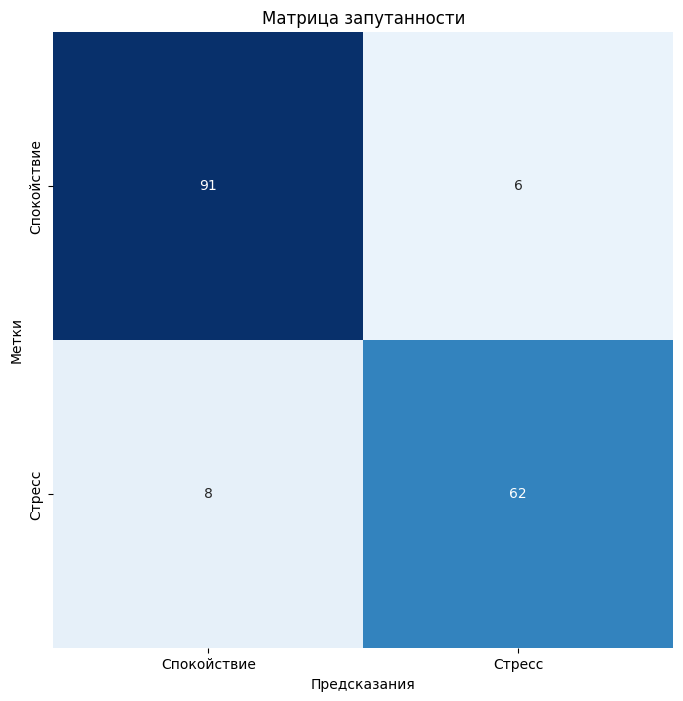

Classification Report:
----------------------
               precision    recall  f1-score   support

      Stress       0.92      0.94      0.93        97
  Not stress       0.91      0.89      0.90        70

    accuracy                           0.92       167
   macro avg       0.92      0.91      0.91       167
weighted avg       0.92      0.92      0.92       167



In [115]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(2) + 0.5, ['Спокойствие', 'Стресс'])
plt.yticks(np.arange(2) + 0.5, ['Спокойствие', 'Стресс'])
plt.xlabel("Предсказания")
plt.ylabel("Метки")
plt.title("Матрица запутанности")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [35]:
with open(r"C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Признаки\features_stress_masha_01.npy", mode='rb') as f:
    features_stress = np.load(f)

In [108]:
with open(r"C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Признаки\features_stress_masha_01.npy", mode='rb') as f:
    features_stress = np.load(f)

In [84]:
with open(r"C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Признаки\features_relax_masha_01.npy", mode='rb') as f:
    features_relax = np.load(f)

In [104]:
# X_valid, y_valid = features_relax[:, 1:], features_relax[:, 0]
X_valid, y_valid = features_relax[42:, 1:], features_relax[42:, 0]

In [109]:
X_valid, y_valid = features_stress[5:, 1:], features_stress[5:, 0]

In [26]:
X_valid.shape

(180, 352)

In [110]:
valid = torch.tensor(X_valid.astype(np.float32))
valid_target = torch.tensor(y_valid, dtype=torch.long)
valid_dataset = torch.utils.data.TensorDataset(valid, valid_target)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [114]:
y_test = []
y_pred = []
for X, y in valid_loader:
    y_test.extend(y)
    pred = stress_nn(X.to(device))
    y_pred.extend(pred.detach().cpu().argmax(dim=1))
cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.93      0.97        60

    accuracy                           0.93        60
   macro avg       0.50      0.47      0.48        60
weighted avg       1.00      0.93      0.97        60



C:\Users\Арсений\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Арсений\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Арсений\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [107]:
cm

array([[98, 40],
       [ 0,  0]], dtype=int64)

In [91]:
all_y_test.extend(y_test)
all_y_pred.extend(y_pred)

NameError: name 'all_y_test' is not defined

In [51]:
clr = classification_report(all_y_test, all_y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.97      0.81      0.89       138
           1       0.69      0.95      0.80        60

    accuracy                           0.85       198
   macro avg       0.83      0.88      0.84       198
weighted avg       0.89      0.85      0.86       198



In [96]:
cm

array([[100,  38],
       [  0,   0]], dtype=int64)